In [6]:
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from genomics.popgen.pca import plot
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

In [7]:
f = open('../Chapter06/relationships_w_pops_041510.txt')
ind_pop = {}
f.readline() # header
for l in f:
    toks = l.rstrip().split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    pop = toks[-1]
    ind_pop['/'.join([fam_id, ind_id])] = pop
f.close()

In [8]:
f = open('../Chapter06/hapmap10_auto_noofs_ld_12.ped')
ninds = 0
ind_order = []
for line in f:
    ninds += 1
    toks = line[:100].replace(' ', '\t').split('\t') #  for speed
    fam_id = toks[0]
    ind_id = toks[1]
    ind_order.append('%s/%s' % (fam_id, ind_id))
nsnps = (len(line.replace(' ', '\t').split('\t')) - 6) // 2
f.close()

In [9]:
pca_array = np.empty((ninds, nsnps), dtype=int)
print(pca_array.shape)
f = open('../Chapter06/hapmap10_auto_noofs_ld_12.ped')
for ind, line in enumerate(f):
    snps = line.replace(' ', '\t').split('\t')[6:]
    for pos in range(len(snps) // 2):
        a1 = int(snps[2 * pos])
        a2 = int(snps[2 * pos + 1])
        my_code = a1 + a2 - 2
        pca_array[ind, pos] = my_code
f.close()
"""
PLINK PED files for numeric genotype data typically encode alleles as numbers.
A common convention is that:

    Homozygous for the reference allele is encoded as 1 1, so 1 + 1 - 2 = 0.
    Heterozygous is encoded as 1 2, so 1 + 2 - 2 = 1.
    Homozygous for the alternate allele is encoded as 2 2, so 2 + 2 - 2 = 2.

Therefore, my_code converts the two-allele representation into a single number 
representing the number of alternate alleles.
"""

(1198, 54999)


'\nPLINK PED files for numeric genotype data typically encode alleles as numbers.\nA common convention is that:\n\n    Homozygous for the reference allele is encoded as 1 1, so 1 + 1 - 2 = 0.\n    Heterozygous is encoded as 1 2, so 1 + 2 - 2 = 1.\n    Homozygous for the alternate allele is encoded as 2 2, so 2 + 2 - 2 = 2.\n\nTherefore, my_code converts the two-allele representation into a single number \nrepresenting the number of alternate alleles.\n'

In [10]:
my_pca = PCA(n_components=8)
my_pca.fit(pca_array) # computes components
trans = my_pca.transform(pca_array) # transform my array, projecting each individual’s genotype vector onto the new 8-dimensional space

(<Figure size 1500x800 with 5 Axes>,
 [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >])

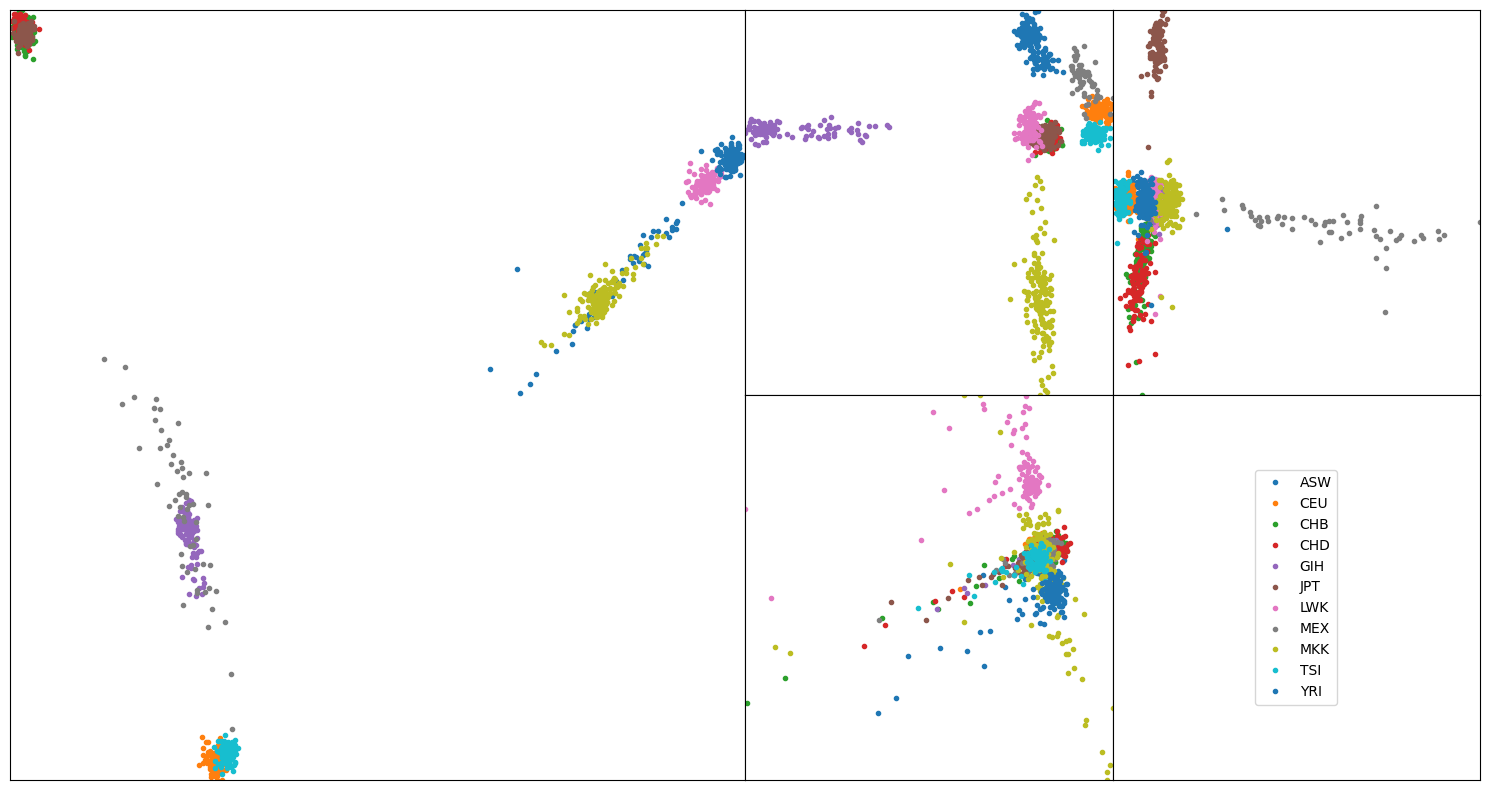

In [12]:
sc_ind_comp = {}
for i, ind_pca in enumerate(trans):
    sc_ind_comp[ind_order[i]] = ind_pca # ind_order[i] = 'fam_id/ind_id'
plot.render_pca_eight(sc_ind_comp, cluster=ind_pop)

In [14]:
all_array = np.empty((ninds, nsnps), dtype=int)
f = open('../Chapter06/hapmap10_auto_noofs_ld_12.ped')
for ind, line in enumerate(f):
    snps = line.replace(' ', '\t').split('\t')[6:]
    for pos in range(len(snps) // 2):
        a1 = int(snps[2 * pos])
        a2 = int(snps[2 * pos + 1])
        my_code = a1 + a2 - 2
        all_array[ind, pos] = my_code
f.close()

In [15]:
predict_case = all_array[-1, :]
pca_array = all_array[:-1,:]

last_ind = ind_order[-1] # 'fam_id/ind_id'
last_ind, ind_pop[last_ind]

('Y076/NA19124', 'YRI')

(<Figure size 1500x800 with 1 Axes>, <Axes: xlabel='PC 1', ylabel='PC 2'>)

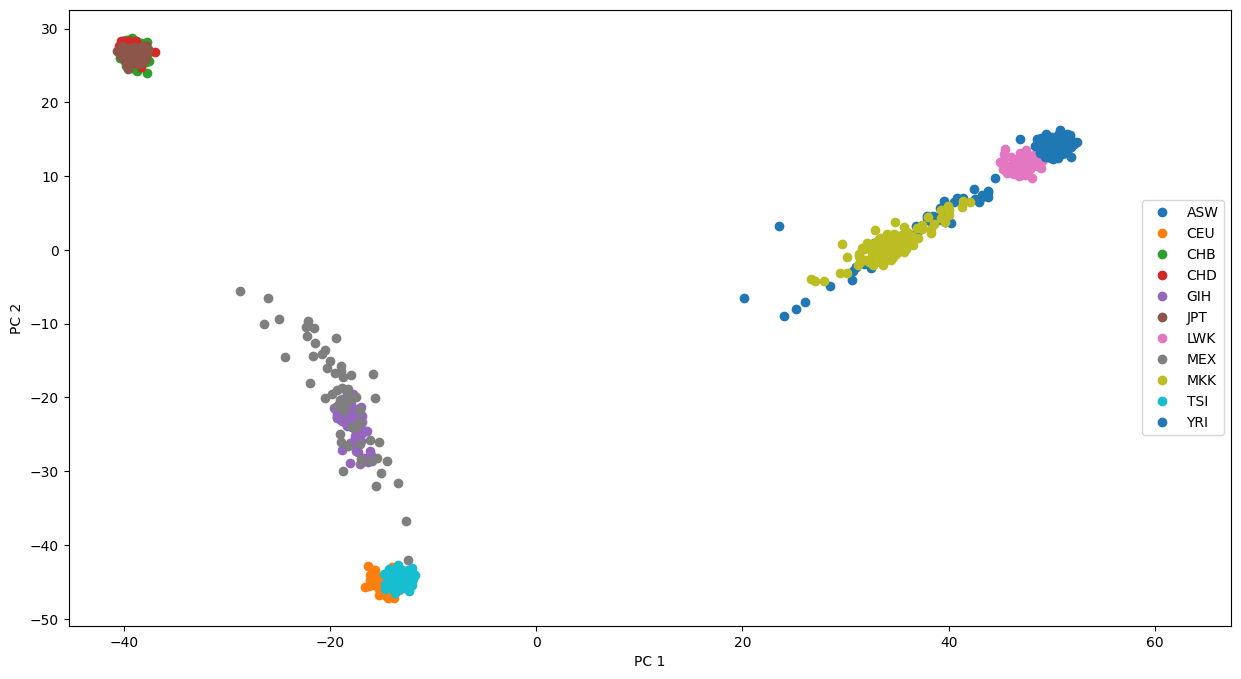

In [16]:
my_pca = PCA(n_components=2)
my_pca.fit(pca_array)
trans = my_pca.transform(pca_array)

sc_ind_comp = {}
for i, ind_pca in enumerate(trans):
    sc_ind_comp[ind_order[i]] = ind_pca
plot.render_pca(sc_ind_comp, cluster=ind_pop)

In [34]:
def plot_kmeans_pca(trans, kmeans):
    """
    This displays a colored background showing the regions where the KMeans algorithm 
    predicts each cluster.
    
    trans:
    A two-dimensional NumPy array of shape (n_samples, 2). Each row represents an 
    individual’s coordinates in the PCA space (i.e. the first two principal components).
    
    kmeans:
    A fitted KMeans clustering object (from scikit-learn) that has been trained on the 
    PCA data. It is used to predict the cluster membership for any new points in the PCA 
    space.
    """
    x_min, x_max = trans[:, 0].min() - 1, trans[:, 0].max() + 1
    y_min, y_max = trans[:, 1].min() - 1, trans[:, 1].max() + 1
    mesh_x, mesh_y = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))

    """
    k_surface is a two-dimensional array where each element indicates the predicted 
    cluster for that particular (x, y) coordinate in the PCA space.
    """
    k_surface = kmeans.predict(np.c_[mesh_x.ravel(), mesh_y.ravel()]).reshape(mesh_x.shape)
    fig, ax = plt.subplots(1,1, dpi=300)
    """
    k_surface (the 2D array of predicted cluster labels) is used as the image data.
    origin="lower":
    Sets the origin of the image to the lower left corner.
    cmap=plt.cm.Pastel1:
    Uses the “Pastel1” colormap to assign colors to the different cluster labels.
    extent=(mesh_x.min(), mesh_x.max(), mesh_y.min(), mesh_y.max()):
    Specifies the coordinate ranges for the x and y axes so that the image 
    aligns properly with the PCA coordinate system.
    """
    ax.imshow(
        k_surface, origin="lower", cmap=plt.cm.Pastel1,
        extent=(mesh_x.min(), mesh_x.max(), mesh_y.min(), mesh_y.max()),
    )

    ax.plot(trans[:, 0], trans[:, 1], "k.", markersize=2)
    ax.set_title("KMeans clustering of PCA data")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

<Axes: title={'center': 'KMeans clustering of PCA data'}>

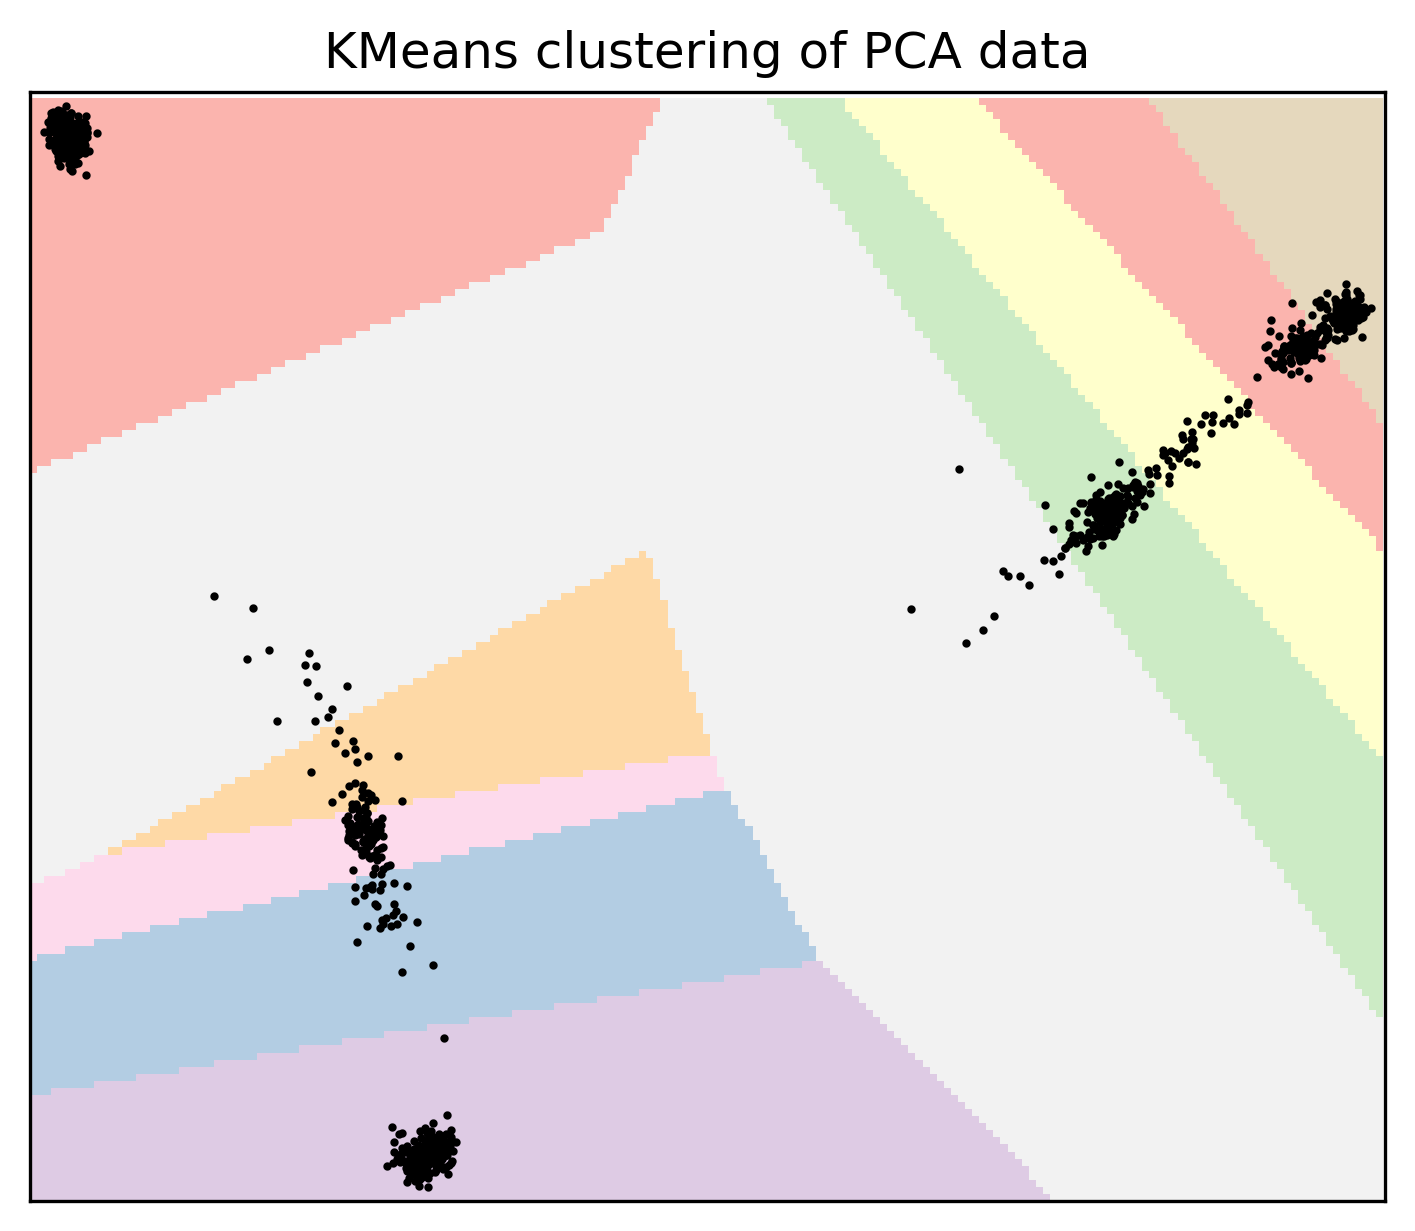

In [35]:
kmeans11 = KMeans(n_clusters=11).fit(trans)
plot_kmeans_pca(trans, kmeans11)

<Axes: title={'center': 'KMeans clustering of PCA data'}>

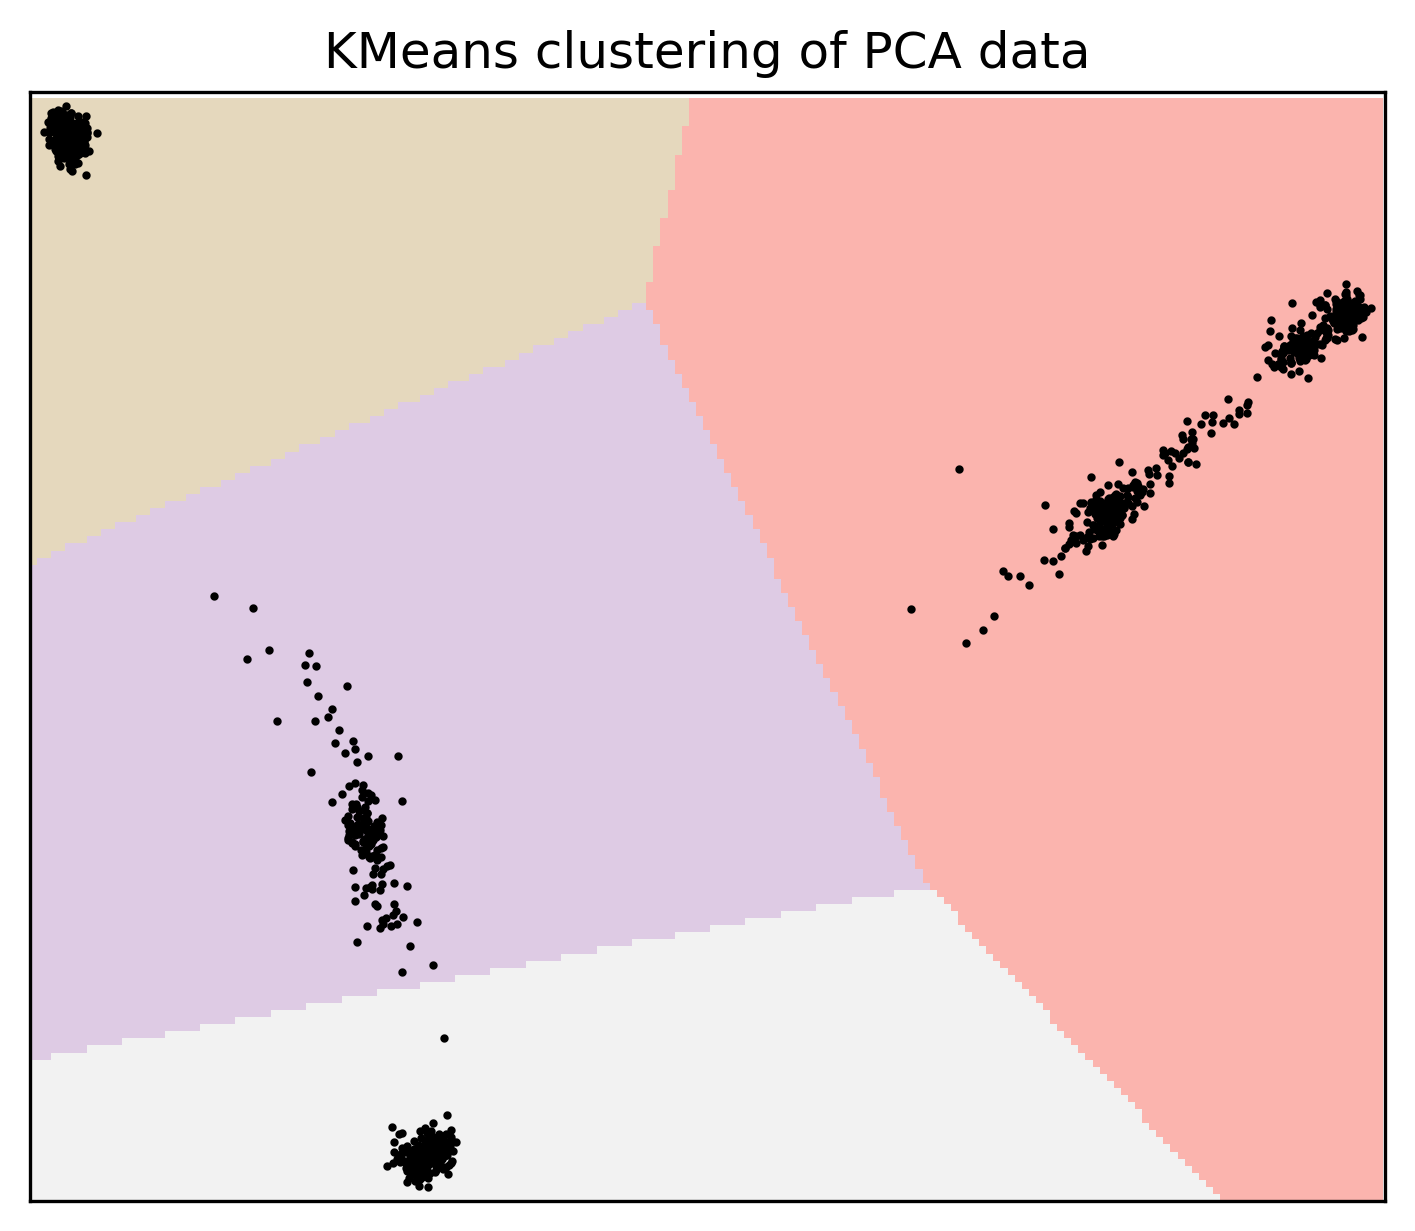

In [36]:
kmeans4 = KMeans(n_clusters=4).fit(trans)
plot_kmeans_pca(trans, kmeans4)

In [38]:
pca_predict = my_pca.transform([predict_case])
kmeans4.predict(pca_predict)


array([0], dtype=int32)

In [39]:
last_train = ind_order[-2]
last_train, ind_pop[last_train]
kmeans4.predict(trans)[0]

0

In [17]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names


--2025-02-10 00:01:51--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
128.195.10.252ive.ics.uci.edu (archive.ics.uci.edu)... 
connected. to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... 
200 OKequest sent, awaiting response... 
Length: unspecified
Saving to: ‘breast-cancer-wisconsin.data’

breast-cancer-wisco     [ <=>                ]  19.42K  --.-KB/s    in 0.08s   

2025-02-10 00:01:51 (239 KB/s) - ‘breast-cancer-wisconsin.data’ saved [19889]

--2025-02-10 00:01:51--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
connected. to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... 
200 OKequest sent, awaiting response... 
Length: unspecified
Saving to: ‘breast-cancer-wisconsin.names’

breast-cancer-wisco     [ <=>                ]   5.52K  --.-KB/s    in 0s   

In [18]:
f = open('breast-cancer-wisconsin.data')
w = open('clean.data', 'w')
for line in f:
    if line.find('?') > -1:
        continue
    w.write(line)
f.close()
w.close()


In [19]:
column_names = [
    'sample_id', 'clump_thickness', 'uniformity_cell_size',
    'uniformity_cell shape', 'marginal_adhesion',
    'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses',
    'class'
]
samples = pd.read_csv('clean.data', header=None, names=column_names, index_col=0)
samples.head()

,clump_thickness,uniformity_cell_size,uniformity_cell shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
sample_id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [20]:
training_input = samples.iloc[:,:-1]
target = samples.iloc[:,-1].apply(lambda x: 0 if x == 2 else 1)

In [21]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(training_input, target)

DecisionTreeClassifier(max_depth=3)

In [22]:
importances = pd.Series(clf.feature_importances_ * 100, 
                        index=training_input.columns).sort_values(ascending=False)
importances

uniformity_cell_size           83.972870
uniformity_cell shape           7.592903
bare_nuclei                     4.310045
clump_thickness                 4.124183
marginal_adhesion               0.000000
single_epithelial_cell_size     0.000000
bland_chromatin                 0.000000
normal_nucleoli                 0.000000
mitoses                         0.000000
dtype: float64

In [23]:
100 * clf.score(training_input, target)

96.33967789165446

[Text(0.5, 0.875, 'uniformity_cell_size <= 2.5\ngini = 0.455\nsamples = 683\nvalue = [444, 239]\nclass = Benign'),
 Text(0.25, 0.625, 'bare_nuclei <= 5.5\ngini = 0.056\nsamples = 418\nvalue = [406, 12]\nclass = Benign'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'clump_thickness <= 6.5\ngini = 0.024\nsamples = 410\nvalue = [405, 5]\nclass = Benign'),
 Text(0.0625, 0.125, 'gini = 0.01\nsamples = 405\nvalue = [403, 2]\nclass = Benign'),
 Text(0.1875, 0.125, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]\nclass = Malignant'),
 Text(0.375, 0.375, 'clump_thickness <= 2.5\ngini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = Malignant'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Benign'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = Malignant'),
 Text(0.75, 0.625, 'uniformity_cell shape <= 2.5\ngini = 0.246\nsamples = 265\nvalue = [38, 227]\nclass = Malignant'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'clump_thickness <= 5.5\

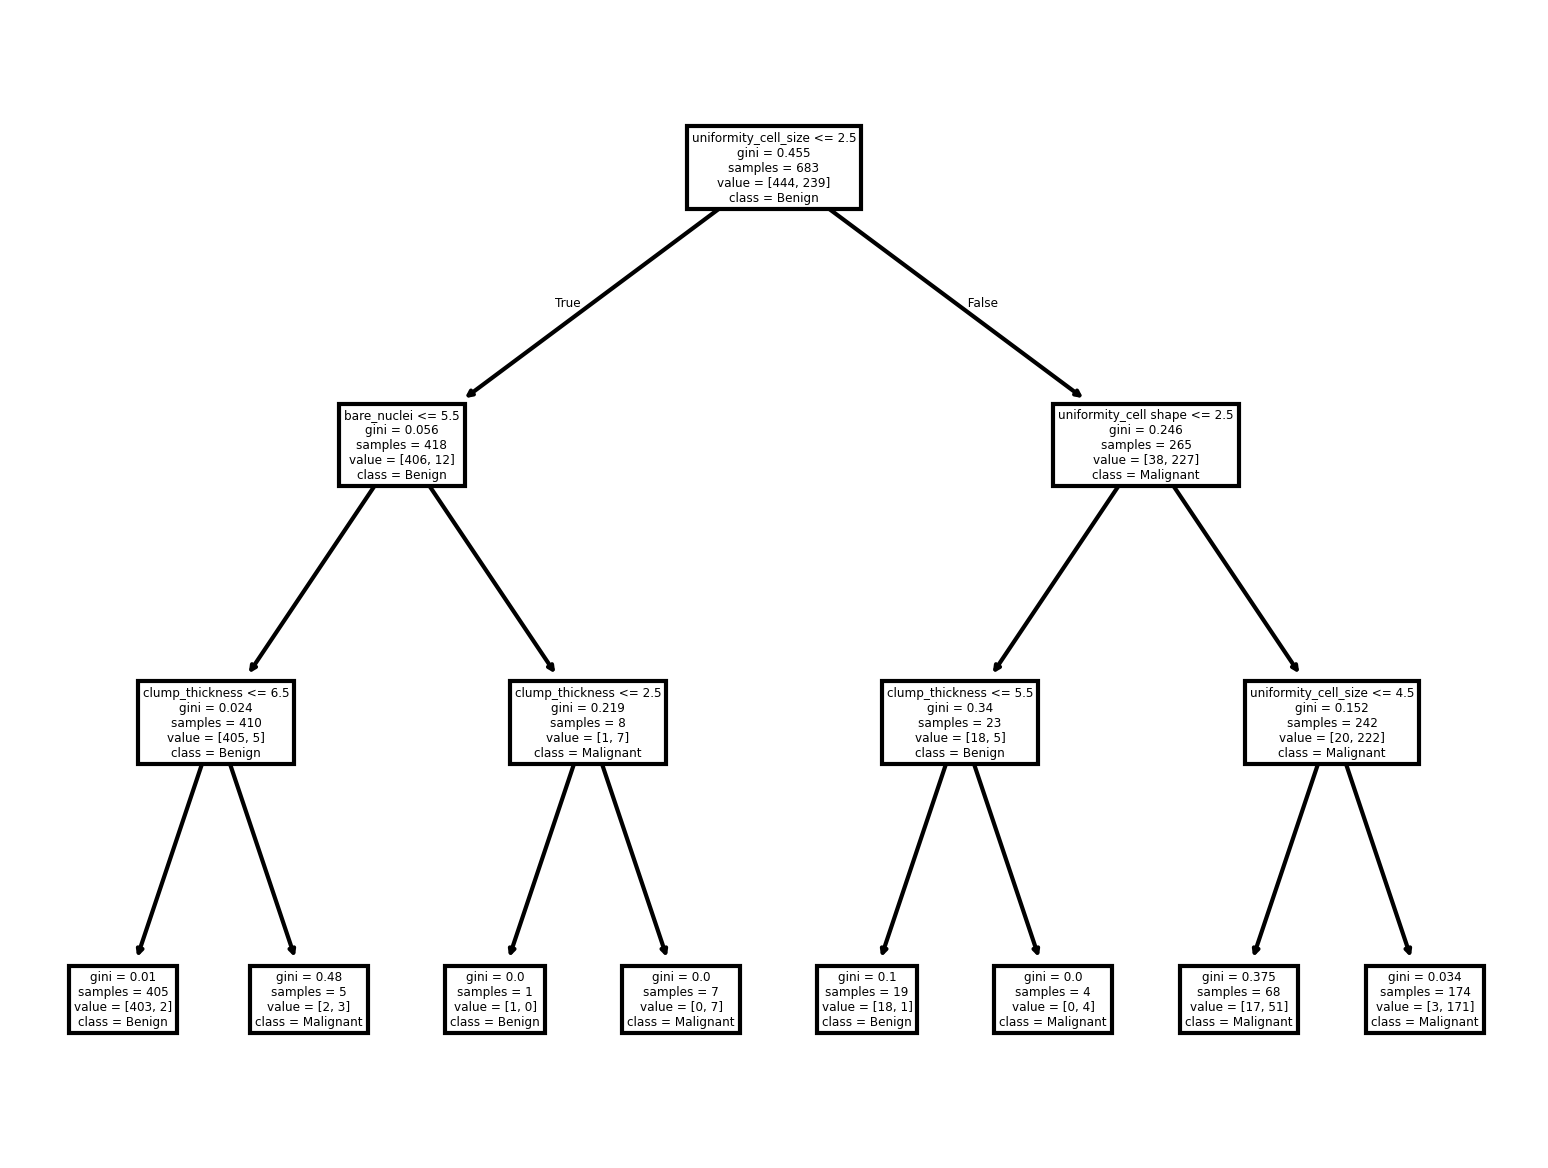

In [24]:
fig, ax = plt.subplots(1, dpi=300)
tree.plot_tree(clf,ax=ax, feature_names=training_input.columns, class_names=['Benign', 'Malignant'])

In [25]:
clf = RandomForestClassifier(max_depth=3, n_estimators=200)

In [27]:
clf.fit(training_input, target)

RandomForestClassifier(max_depth=3, n_estimators=200)

In [29]:
importances = pd.Series(clf.feature_importances_ * 100,
                        index=training_input.columns).sort_values(ascending=False)
importances

uniformity_cell_size           33.570342
uniformity_cell shape          19.735014
bare_nuclei                    17.075058
bland_chromatin                12.092899
single_epithelial_cell_size     7.529591
normal_nucleoli                 5.984944
clump_thickness                 2.932729
marginal_adhesion               0.876789
mitoses                         0.202634
dtype: float64

In [30]:
clf.score(training_input, target)

0.9795021961932651

In [32]:
for test_size in [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]:
    X_train, X_test, y_train, y_test = train_test_split(
        training_input, target, test_size=test_size)
    tclf = RandomForestClassifier(max_depth=3)
    tclf.fit(X_train, y_train)
    score = tclf.score(X_test, y_test)
    print(f'{1 - test_size:.1%} {score:.2%}')

99.0% 100.00%
90.0% 95.65%
80.0% 96.35%
50.0% 97.95%
20.0% 97.07%
10.0% 93.98%
1.0% 77.84%
